# Assignment 2: Machine Learning On MNIST Data Set

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets as datasets

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

np.set_printoptions(precision=4, suppress=True)

In [2]:
data = tf.keras.datasets.mnist.load_data(path='/data/shared/datasets/mnist.npz')

#
# By default, the data is already split into training and testing data
#
train_data, test_data = data

#
# Data consists of one tensor for the images, and another tensor for the label.
#
x_train, y_train = train_data
x_test, y_test = test_data

#
# We will also renormalize the input to 0-1
#
x_train = x_train / 255
x_test = x_test / 255

print('x_train', x_train.shape)
print('y_train', y_train.shape)

x_train (60000, 28, 28)
y_train (60000,)


# Some Functions

## Construct a softmax activation layer

Construct a softmax activation layer.

In [3]:
layer = layers.Activation('softmax')

Use the layer to process 3D vectors.

Note that the output of a softmax layer is **always** a valid probability distribution.

So, we can think of the output `y` is the probabilities being determined by the `softmax` activation layer based on its input `x`.

In [4]:
x = np.array([
    [30, 20, 25],
    [3, 2, 2.5],
    [1.0, 3.5, -1],
    [-1.2, -3.5, -1],
])

y = layer(x)
y.numpy()

array([[0.9933, 0.    , 0.0067],
       [0.5065, 0.1863, 0.3072],
       [0.0751, 0.9148, 0.0102],
       [0.4307, 0.0432, 0.5261]], dtype=float32)

## Convert probability distribution to sparse encoding

Implement a function that converts a TF tensor of probability distributions to sparse integer encoding of categories.

In [5]:
def to_sparse(x):
    return tf.convert_to_tensor(np.argmax(x, axis=1), dtype=tf.int64) 

In [6]:
y_sparse = to_sparse(y)
y_sparse

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 1, 2])>

## Convert sparse encoding to one-hot encoding

Implement a function that converse a sequence of sparse encoding of categories into one-hot encodings.

In [7]:
#
# Returns a NumPy array that is the one-hot encoding
# of x where there are `num_categories`.
#
def to_onehot(x, num_categories):
        return keras.utils.to_categorical(y=x,num_classes=num_categories,dtype=None)
#         inputs = tf.one_hot(x, num_categories)
#         return np.array(inputs.numpy().tolist())

In [8]:
y_onehot = to_onehot(y_sparse, 3)
y_onehot

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Cross Entropy

In this workunit, we will evaluate the cross entropy between
two distributions: the output probability `y`, and the one hot encoding `y_onehot`.

In [9]:
crossentropy = losses.categorical_crossentropy(y_true=y_onehot,y_pred=y)

In [10]:
crossentropy.numpy()

array([0.0068, 0.6803, 0.0891, 0.6423], dtype=float32)

## Sparse Cross Entropy

Very often, we have the true categories as sparse integer encodings, like `y_sparse` instead of the one-hot encodings.  This is because sparse encoding is much more memory efficient.

Keras provides a loss function `sparse_categorical_crossentropy` that computes the cross entropy between `y_sparse` and `y` directly.

In [11]:
sparse_crossentropy = losses.sparse_categorical_crossentropy(y_true=y_sparse,y_pred=y)

We can verify that the two should be identical.

In [12]:
sparse_crossentropy.numpy()

array([0.0068, 0.6803, 0.0891, 0.6423], dtype=float32)

In [13]:
np.allclose(sparse_crossentropy.numpy(), crossentropy.numpy())

True

# Multi-category Classification

## Model construction

Build a simple 10-way classifier.

1. You should use an input layer with shape (28, 28).

2. You should have a reshape layer that converts the input images
   to shape (758,)
   
3. Then, it should be followed by a dense layer out 10 output units, and no activation function.

4. Finally, we need an activation layer with softmax activation.

Name your layers and model accordingly to match the expected model summary.

In [14]:
def build_simple_model():
    model = models.Sequential([
        layers.Input(shape=(28,28)),
        layers.Reshape((28*28,), name='flatten'),
        layers.Dense(10, name='dense'),
        layers.Activation('softmax', name='softmax'),
    ], name='simple_model')
    return model

In [15]:
simple_model = build_simple_model()
simple_model.summary()

Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Reshape)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Compile Model

Implement a function that compiles a Keras model with

1. Loss function being the sparse categorical cross entropy.

2. Optimizer being the `Adam` optimizer with the given learning rate.

3. Metrics include accuracy.

In [16]:
def compile_model(model, learing_rate=0.01):
    model.compile(optimizer=optimizers.Adam(learing_rate), loss=losses.SparseCategoricalCrossentropy(), metrics=['acc'])

In [17]:
from pprint import pformat

compile_model(simple_model, 1e-1)
simple_model.optimizer.get_config()
print("Loss Function:\n", pformat(simple_model.loss.get_config()))
print("-" * 30)
print("Optimizer:\n", pformat(simple_model.optimizer.get_config()))

Loss Function:
 {'from_logits': False,
 'name': 'sparse_categorical_crossentropy',
 'reduction': 'auto'}
------------------------------
Optimizer:
 {'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.1,
 'name': 'Adam'}


# Training

## Training on MNIST

Implement a function `train(model, x, y)` that will train the model with epochs=10.

The function must return the training history object.

In [18]:
def train(model, x_data, y_data):
    return model.fit(x_data, y_data, epochs=10)

In [19]:
simple_model = build_simple_model()
compile_model(simple_model)
log_simple = train(simple_model, x_train, y_train)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4341 - acc: 0.8700
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3395 - acc: 0.9088
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3228 - acc: 0.9134
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3109 - acc: 0.9176
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3202 - acc: 0.9151
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3072 - acc: 0.9173
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3146 - acc: 0.9159
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3146 - acc: 0.9160
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3152 - acc: 0.9187
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3057 - acc: 0.9197


Check that the model performs reasonable well.

In [20]:
log_simple.history['acc'][-1] > 0.9

True

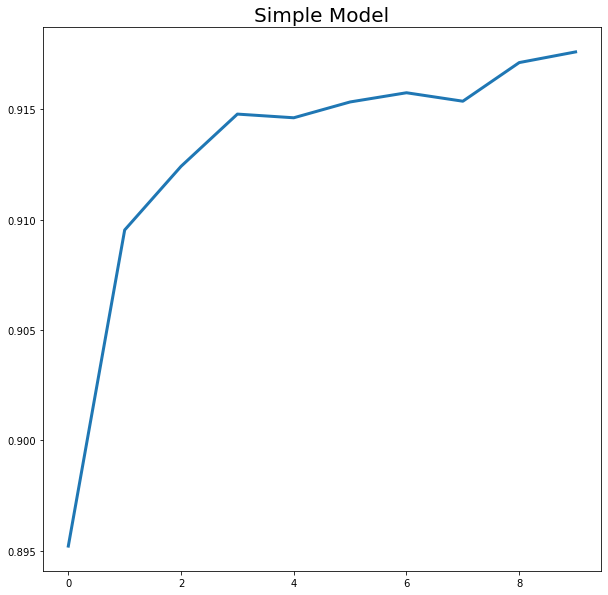

In [21]:
pl.figure(figsize=(10, 10))
pl.plot(log_simple.history['acc'], linewidth=3);
pl.title('Simple Model', fontsize=20);

## Multi-layer Models

## Building multi-layer models

Implement a function that builds multi-layer model, named `multilayer_model`.

The model must have `num_layers` of Dense layers.

The first `(num_layers - 1)` dense layers
are `Dense(100)`, named as `dense_i`, and followed by a separate activation layer using
`relu` activation function.

The last dense layer is `Dense(10)` followed by a separate activation layer using `softmax` as the activation function.  The last two years are named `dense_out` and `activation_out` respectively.

In [22]:
def build_multilayer_model(num_layers):
    model = models.Sequential([
        layers.Input(shape=(28,28)),
        layers.Reshape((28*28,), name='flatten'),
    ], name='multilayer_model')
    i = 0
    inter_layers_count = num_layers - 1
    while i < inter_layers_count:
        dense_name = 'dense_' + str(i)
        model.add(layers.Dense(100, name=dense_name))
        activation_name = 'activation_' + str(i)
        model.add(layers.Activation('relu', name=activation_name))
        i+=1
    model.add(layers.Dense(10, name='dense_out'))
    model.add(layers.Activation('softmax', name='activation_out'))
    return model

In [23]:
multilayer_model = build_multilayer_model(5)

multilayer_model.summary()

Model: "multilayer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Reshape)            (None, 784)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               78500     
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)          

In [24]:
compile_model(multilayer_model)

In [25]:
log_multi = train(multilayer_model, x_train, y_train)

Epoch 1/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.4678 - acc: 0.8598
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2295 - acc: 0.9440
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1886 - acc: 0.9543: 7s - loss: 0.1828 - acc: 0 - - ETA: 0s - loss: 0.1882 - acc:
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1884 - acc: 0.9546
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1945 - acc: 0.9530
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1652 - acc: 0.9609: 0s - loss: 0.1652 - acc: 0.960
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1626 - acc: 0.9613
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1533 - acc: 0.9641
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1315 - acc: 0.9687
Epoch 10/10
1875/1875 [=

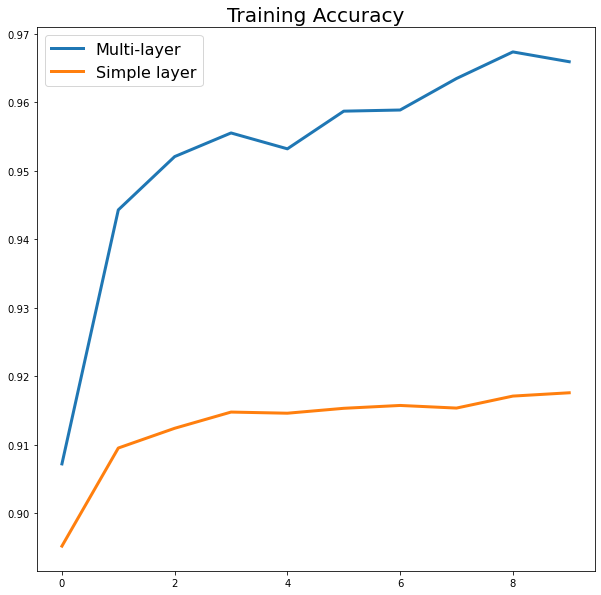

In [26]:
pl.figure(figsize=(10, 10))
pl.plot(log_multi.history['acc'], linewidth=3);
pl.plot(log_simple.history['acc'], linewidth=3);

pl.legend(['Multi-layer', 'Simple layer'], fontsize=16)

pl.title('Training Accuracy', fontsize=20);

In [27]:
print("Simple < Multilayer:", log_simple.history['acc'][-1] < log_multi.history['acc'][-1])
print("Multilayer > 0.95:", 0.95 < log_multi.history['acc'][-1])

Simple < Multilayer: True
Multilayer > 0.95: True
